# Utilities / Tools

In [1]:
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Activation , Dense , Dropout ,Flatten , BatchNormalization , Conv2D , MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import classification_report , confusion_matrix , ConfusionMatrixDisplay,recall_score,precision_score,f1_score,roc_auc_score , accuracy_score
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping , ModelCheckpoint
from sklearn import svm
from glob import iglob
from collections import Counter
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = "ignore" , category =FutureWarning)
%matplotlib inline
# Import OpenCV
import cv2 as cv

# Utility
import os
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob

# Ignore warning
import warnings
warnings.filterwarnings('ignore')





# Settings/Configuration

In [2]:
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
SIZE = 224
# Keras settings
TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 0.0001
total_training_samples = 192
training_batchSize = 16
total_validation_samples = 63
valid_batchSize = 16
#MODEL_PATH = os.path.join("skin diseases classification.h5")
model_PATH3 = os.path.join("skin diseases classification3.h5")

## tree directory , train , valid , test folders. this part handled in the pervious notebook.

In [3]:
base_dataset_folder = 'C:/Dataset/splitted_images'
train_folder = 'C:/Dataset/splitted_images/train'
valid_folder = 'C:/Dataset/splitted_images/val'
test_folder = 'C:/Dataset/splitted_images/test'

### Construct an instance of the ImageDataGenerator class
### Pass the augmentation parameters through the constructor. 
### here we do the data augmentation on the 'fly' as it augments the data image through the training model phase and identifies the batch size and epochs number as stop flag to stop generate more data(augment).

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range = 45,
        brightness_range =[0.3,0.9] )

train_generator = train_datagen.flow_from_directory(
        os.path.join(base_dataset_folder, train_folder),
        target_size=IMAGE_SIZE,
        batch_size=TRAIN_BATCH_SIZE,
        classes = ['normal','monkeypox','chickenpox'],
        class_mode='categorical', 
        #save_to_dir='augmented', 
       # save_prefix='aug', 
        #save_format= "png", 
        shuffle=True)

Found 279 images belonging to 3 classes.


## this function to display or plot dataset classes

In [5]:
def percentage_value(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset_description(path, title):
    classes = []
    for filename in iglob(os.path.join(path, "**","*.png")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])

    classes_cnt = Counter(classes)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140 , normalize=True)

    plt.title(title)    
    plt.show()

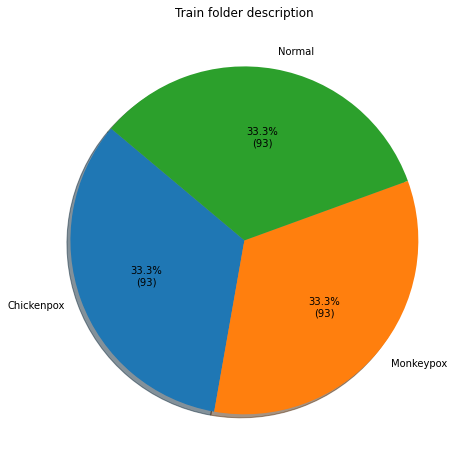

In [6]:
plot_dataset_description(os.path.join(base_dataset_folder, train_folder), "Train folder description")

In [7]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        os.path.join(base_dataset_folder,valid_folder),
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        batch_size= VAL_BATCH_SIZE,
        classes = ['normal','monkeypox','chickenpox'],
        class_mode='categorical', 
        shuffle=False)

Found 120 images belonging to 3 classes.


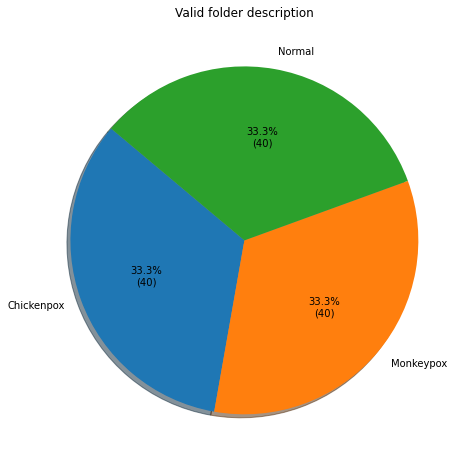

In [8]:
plot_dataset_description(os.path.join(base_dataset_folder, valid_folder), "Valid folder description")

In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        os.path.join(base_dataset_folder, test_folder),
        target_size=IMAGE_SIZE,
        batch_size=VAL_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 117 images belonging to 3 classes.


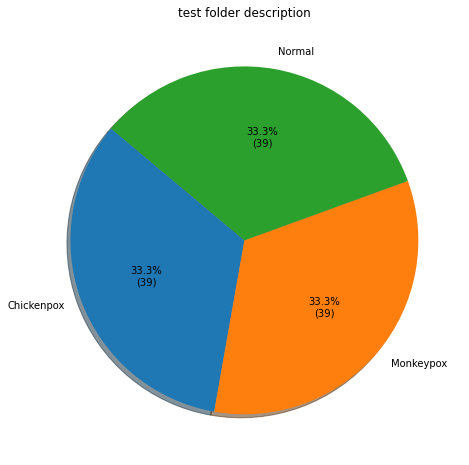

In [10]:
plot_dataset_description(os.path.join(base_dataset_folder, test_folder), "test folder description")

## key : value representation for 3 classes.
## 0 ---> key , 'normal' ----> valu

In [11]:
classes = {value : key for key, value in train_generator.class_indices.items()}
print(classes)

{0: 'normal', 1: 'monkeypox', 2: 'chickenpox'}


# As we using Transfer learning
### First : load the pre-trained ResNet50 model without the top layer ---> set false.

In [12]:
model = ResNet50()
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [13]:
def create_model2(input_shape): #n_classes , optimizer=Adam(learning_rate = LEARNING_RATE)):
    # we need to know what application will transfer its knowledge to serve my problem in our case(skin diseases calssifier)
    conv_base = ResNet50(include_top = False , weights = 'imagenet' , input_shape = INPUT_SHAPE)
    for layer in conv_base.layers[:6]:
        layer.trainable = False
    #for i , layer in enumerate(conv_base.layers):
       # print(i , layer.name , "-" , layer.trainable)
    # add the output layer 
    
    #top_model = conv_base.output 
    #top_model= GlobalAveragePooling2D()(top_model)
    #top_model = Flatten(name = 'flatten')(top_model)
    #top_model = Dense(10 , activation = 'relu')(top_model)

    #output_layer = Dense(n_classes , activation = 'softmax')(top_model)
  # group the new input and output that re-written by us .
    #model = Model(inputs = conv_base.input , outputs = output_layer)
    #model.compile(optimizer = optimizer , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    #return model
    return conv_base

In [14]:
resnet_weights = create_model2(INPUT_SHAPE)

In [15]:
resnet_weights.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [16]:
#monitor_for_overfit = EarlyStopping(monitor='val_loss' ,verbose=1, patience=3)
#best_result = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [17]:
#model_history = modified_resnet.fit_generator(train_generator,
    #epochs=EPOCHS,
    #steps_per_epoch = train_generator.samples//train_generator.batch_size,
    #verbose=2,
    #callbacks=[monitor_for_overfit,best_result],
    #validation_data= val_generator,
    #validation_steps= val_generator.samples//val_generator.batch_size
    #) 

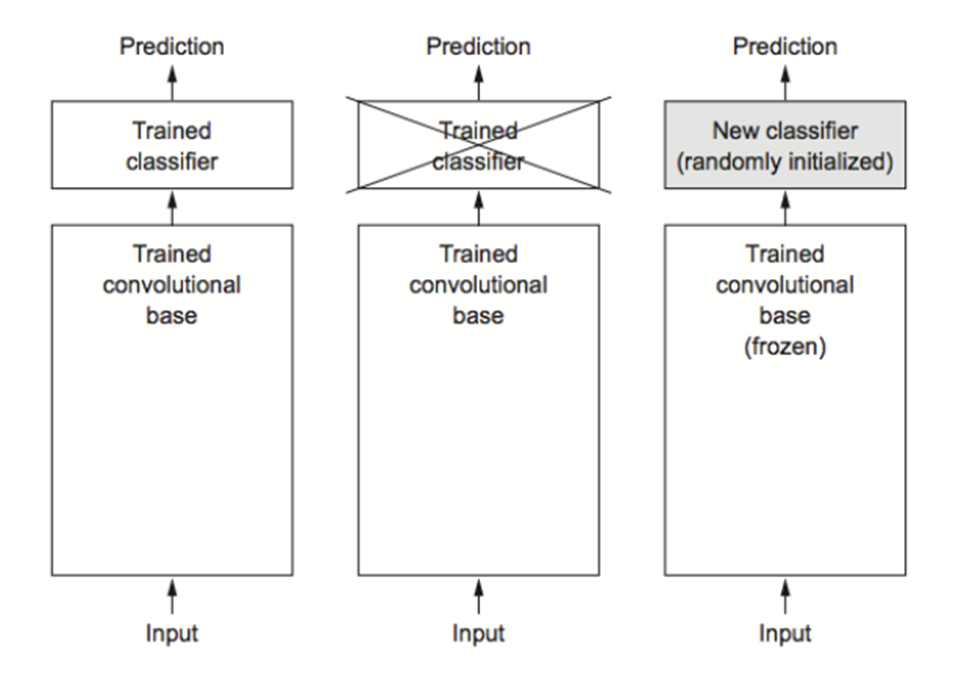


In [18]:
train_data = 'C:/Dataset/splitted_images2/train'
valid_data =  'C:/Dataset/splitted_images2/val'

In [19]:
#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("C:/Dataset/splitted_images2/train/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        print(img_path)
        img = cv.imread(img_path, cv.IMREAD_COLOR)       
        img = cv.resize(img, (SIZE, SIZE))
        img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

Chickenpox
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox1.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox10.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox100.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox101.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox102.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox103.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox104.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox105.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox106.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox107.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox11.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox12.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox13.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox15.png
C:/Dataset/splitted_images2/train\Chickenpox\chickenpox16.png
C:/Dataset/splitted_images2/train\Chickenpox\chicken

C:/Dataset/splitted_images2/train\Monkeypox\monkeypox60.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox61.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox62.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox63.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox65.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox66.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox67.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox68.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox70.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox71.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox72.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox73.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox75.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox77.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox78.png
C:/Dataset/splitted_images2/train\Monkeypox\monkeypox8.png
C:/Dataset/splitted_images2/train\Monkeyp

In [20]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)


In [21]:
test_images = []
test_labels = [] 
for directory_path in glob.glob("C:/Dataset/splitted_images2/val/*"):
    label2 = directory_path.split("\\")[-1]
    #print(label2)
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        img = cv.resize(img, (SIZE, SIZE))
        img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(label2)

In [22]:
## Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [23]:
le = LabelEncoder()
test_labels_encoded= le.fit_transform(test_labels)
train_labels_encoded= le.fit_transform(train_labels)

In [24]:
X_train , y_train , X_test , y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [25]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [26]:
X_train , X_test = X_train / 255.0 , X_test / 255.0

# extract features for training data
### ResNet50 as feature extractor along with  SVC as classifier instead of hypertune the fully connected layer we just remove it and make the SVC classifier do the jop .

In [27]:
extracted_learning= resnet_weights.predict(X_train)

8/8 [==============================] - 9s 1s/step


In [28]:
extracted_learning.shape

(255, 7, 7, 2048)

In [29]:
features = extracted_learning.reshape(extracted_learning.shape[0], -1)

In [30]:
X_for_SVM = features

In [31]:
X_for_SVM.ndim
print("X_train for train the SVM classifier :",X_for_SVM.shape)

X_train for train the SVM classifier : (255, 100352)


# extract features for testing data

In [32]:
test_features = resnet_weights.predict(X_test)
test_features = test_features.reshape(test_features.shape[0],-1)

2/2 [==============================] - 2s 988ms/step


In [33]:
print("Input for testing data in other word the input for getting prediction of that data :",test_features.shape)

Input for testing data in other word the input for getting prediction of that data : (63, 100352)


In [34]:
classifier = svm.SVC(kernel = 'linear' , degree = 8 , gamma="auto")

In [35]:
classifier.fit(X_for_SVM,y_train)

SVC(degree=8, gamma='auto', kernel='linear')

# Predict the response for test features


In [36]:
y_pred = classifier.predict(test_features)

In [37]:
y_pred = le.inverse_transform(y_pred)

In [38]:
type(y_pred)

numpy.ndarray

# testing accuracy


In [39]:
from sklearn import metrics
accuracy_score(test_labels,y_pred)

0.5714285714285714

In [40]:
conf_ma = confusion_matrix(test_labels, y_pred)

<AxesSubplot:>

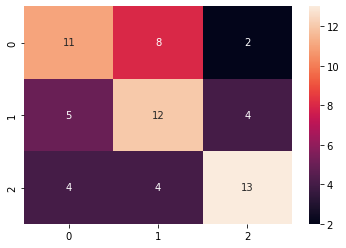

In [41]:
sns.heatmap(conf_ma , annot = True)

In [42]:
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

  Chickenpox       0.55      0.52      0.54        21
   Monkeypox       0.50      0.57      0.53        21
      Normal       0.68      0.62      0.65        21

    accuracy                           0.57        63
   macro avg       0.58      0.57      0.57        63
weighted avg       0.58      0.57      0.57        63



### VGG16 as feature extractor along with SVC as classifier instead of hypertune the fully connected layer we just remove it and make the SVC classifier do the jop .
#### same steps as bove we just extract the train and test data from the prre-trained model and take them to ably fit classifier and finally the prediction as a final step.

In [102]:
vgg16_model = VGG16(include_top = False , weights = 'imagenet' , input_shape = INPUT_SHAPE)
for layer in vgg16_model.layers:
    layer.trainable = False


In [103]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [104]:
extracted_feature_using_train = vgg16_model.predict(X_train)

8/8 [==============================] - 18s 2s/step


In [105]:
extracted_feature_using_train.shape

(255, 7, 7, 512)

In [106]:
features = extracted_feature_using_train.reshape(extracted_feature_using_train.shape[0], -1)

In [86]:
X_for_SVC_vgg16 = features
print(X_for_SVC_vgg16.shape)

(255, 25088)


In [107]:
classifier.fit(X_for_SVC_vgg16,y_train)

SVC(degree=8, gamma='auto', kernel='linear')

In [108]:
extracted_feature_using_test = vgg16_model.predict(X_test)

2/2 [==============================] - 4s 2s/step


In [109]:
extracted_feature_using_test.shape

(63, 7, 7, 512)

In [110]:
X_test_SVM = extracted_feature_using_test.reshape(extracted_feature_using_test.shape[0], -1)

In [111]:
X_test_SVM.shape

(63, 25088)

In [112]:
SVC_predictions =  classifier.predict(X_test_SVM)

In [113]:
SVC_predictions

array([0, 0, 0, 2, 2, 0, 0, 1, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 2, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
      dtype=int64)

In [114]:
SVC_predictions = le.inverse_transform(SVC_predictions)

In [115]:
SVC_predictions

array(['Chickenpox', 'Chickenpox', 'Chickenpox', 'Normal', 'Normal',
       'Chickenpox', 'Chickenpox', 'Monkeypox', 'Monkeypox', 'Chickenpox',
       'Normal', 'Chickenpox', 'Monkeypox', 'Monkeypox', 'Chickenpox',
       'Chickenpox', 'Chickenpox', 'Chickenpox', 'Monkeypox',
       'Chickenpox', 'Normal', 'Monkeypox', 'Monkeypox', 'Monkeypox',
       'Chickenpox', 'Monkeypox', 'Monkeypox', 'Monkeypox', 'Monkeypox',
       'Monkeypox', 'Chickenpox', 'Normal', 'Monkeypox', 'Monkeypox',
       'Monkeypox', 'Monkeypox', 'Monkeypox', 'Chickenpox', 'Monkeypox',
       'Monkeypox', 'Chickenpox', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Monkeypox', 'Normal', 'Normal', 'Normal', 'Normal',
       'Chickenpox', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal',
       'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal'],
      dtype='<U10')

In [116]:
print("Accuracy =", accuracy_score(test_labels , SVC_predictions ))

Accuracy = 0.7301587301587301


In [117]:
conf_ma = confusion_matrix(test_labels ,SVC_predictions)

<AxesSubplot:>

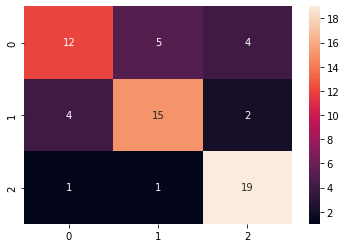

In [118]:
sns.heatmap(conf_ma , annot = True)

In [119]:
print(classification_report(test_labels ,SVC_predictions))

              precision    recall  f1-score   support

  Chickenpox       0.71      0.57      0.63        21
   Monkeypox       0.71      0.71      0.71        21
      Normal       0.76      0.90      0.83        21

    accuracy                           0.73        63
   macro avg       0.73      0.73      0.72        63
weighted avg       0.73      0.73      0.72        63



1/1 [==============================] - 0s 95ms/step
The prediction for this image is:  ['Monkeypox']
The actual label for this image is:  Monkeypox


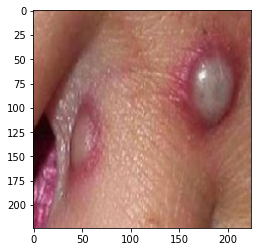

In [121]:
n=np.random.randint(0, X_test.shape[0])
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=vgg16_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
SVC_predictions = classifier.predict(input_img_features)[0] 
SVC_predictions = le.inverse_transform([SVC_predictions])  #Reverse the label encoder to original name
print("The prediction for this image is: ", SVC_predictions)
print("The actual label for this image is: ", test_labels[n])